<a href="https://colab.research.google.com/github/IT21238994/24-25J-169-iTranz/blob/RouteModel_IT21298394/Route_RandomForestClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# Install required libraries
!pip install lightgbm shap imbalanced-learn
!pip install dask[dataframe]

# Import libraries
import pandas as pd
import numpy as np
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Set plot styles
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

In [28]:
# Upload the dataset to Colab
from google.colab import files
uploaded = files.upload()


Saving bus_schedule_sept_nov_2024.csv to bus_schedule_sept_nov_2024.csv


In [29]:
# Load the dataset
file_path = 'bus_schedule_sept_nov_2024.csv'  # Ensure this matches your uploaded file name
df = pd.read_csv(file_path)

# Display the first few rows
print("First 5 rows of the dataset:")
print(df.head())

# Display dataset information
print("\nDataset Information:")
print(df.info())

# Display summary statistics
print("\nSummary Statistics:")
print(df.describe())


First 5 rows of the dataset:
         Date     Day     Time  Route Traffic_Level  Delay (min)  \
0  01.09.2024  Sunday  8:00 AM    380        Medium            1   
1  01.09.2024  Sunday  4:40 PM    380           Low            0   
2  01.09.2024  Sunday  5:30 PM    356           Low            1   
3  01.09.2024  Sunday  3:10 PM    356           Low            1   
4  01.09.2024  Sunday  9:20 AM    380           Low            0   

   Distance (km)  Full Trip Time(min)  Average Speed (kmph)  \
0           10.9                   28                  31.4   
1           10.9                   28                  31.4   
2            9.2                   21                  32.5   
3            9.2                   21                  32.5   
4           10.9                   28                  31.4   

   Average Bus Stop Time(min)  Fare (LKR)  Seat_Availability (%)  \
0                         2.5          77                     41   
1                         2.5          77      

In [30]:
# Check for missing values
print("Missing Values in Each Column:")
print(df.isnull().sum())

# If there are missing values, decide on an imputation strategy
# For demonstration, we'll fill numerical columns with median and categorical with mode

numerical_cols = ['Delay (min)', 'Distance (km)', 'Full Trip Time(min)',
                  'Average Speed (kmph)', 'Average Bus Stop Time(min)',
                  'Fare (LKR)', 'Seat_Availability (%)',
                  'Historical_Peak_Delay (min)']

categorical_cols = ['Traffic_Level', 'Day', 'Route']

# Fill numerical columns with median
for col in numerical_cols:
    df[col].fillna(df[col].median(), inplace=True)

# Fill categorical columns with mode
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Verify again
print("\nMissing Values After Imputation:")
print(df.isnull().sum())


Missing Values in Each Column:
Date                           0
Day                            0
Time                           0
Route                          0
Traffic_Level                  0
Delay (min)                    0
Distance (km)                  0
Full Trip Time(min)            0
Average Speed (kmph)           0
Average Bus Stop Time(min)     0
Fare (LKR)                     0
Seat_Availability (%)          0
Historical_Peak_Delay (min)    0
dtype: int64

Missing Values After Imputation:
Date                           0
Day                            0
Time                           0
Route                          0
Traffic_Level                  0
Delay (min)                    0
Distance (km)                  0
Full Trip Time(min)            0
Average Speed (kmph)           0
Average Bus Stop Time(min)     0
Fare (LKR)                     0
Seat_Availability (%)          0
Historical_Peak_Delay (min)    0
dtype: int64


In [31]:
# Convert categorical variables to string type if not already
for col in ['Traffic_Level', 'Day', 'Route']:
    df[col] = df[col].astype(str)


In [32]:
# Label encoding for categorical features
le_traffic = LabelEncoder()
le_day = LabelEncoder()
le_route = LabelEncoder()

df['Traffic_Level_Encoded'] = le_traffic.fit_transform(df['Traffic_Level'])
df['Day_Encoded'] = le_day.fit_transform(df['Day'])
df['Route_Encoded'] = le_route.fit_transform(df['Route'])

print("\nLabel Encoding completed for 'Traffic_Level', 'Day', and 'Route'.")



Label Encoding completed for 'Traffic_Level', 'Day', and 'Route'.


In [33]:
# Extract hour and minute from Time
def extract_time_features(time_str):
    try:
        time_obj = pd.to_datetime(time_str, format='%I:%M %p')
        return time_obj.hour, time_obj.minute
    except:
        return 12, 0  # Default to noon if parsing fails

df[['Hour', 'Minute']] = df['Time'].apply(lambda x: pd.Series(extract_time_features(x)))

# Represent Hour cyclically
df['Hour_Sin'] = np.sin(2 * np.pi * df['Hour']/24)
df['Hour_Cos'] = np.cos(2 * np.pi * df['Hour']/24)

# Represent Minute cyclically
df['Minute_Sin'] = np.sin(2 * np.pi * df['Minute']/60)
df['Minute_Cos'] = np.cos(2 * np.pi * df['Minute']/60)

print("\nTemporal features extracted and cyclic representations created.")



Temporal features extracted and cyclic representations created.


In [34]:
# Interaction between Delay and Fare
df['Delay_Fare_Interaction'] = df['Delay (min)'] * df['Fare (LKR)']

# Interaction between Seat Availability and Fare
df['Seat_Fare_Interaction'] = df['Seat_Availability (%)'] * df['Fare (LKR)']

print("\nInteraction features created.")



Interaction features created.


In [35]:
# Square of Delay
df['Delay_Squared'] = df['Delay (min)'] ** 2

# Log transformation of Fare to reduce skewness
df['Fare_Log'] = np.log1p(df['Fare (LKR)'])

print("\nNon-linear features created.")



Non-linear features created.


In [36]:
# Check if 'User_ID' exists; if not, create it
if 'User_ID' not in df.columns:
    np.random.seed(42)  # For reproducibility
    num_unique_users = 500  # Adjust based on your data
    df['User_ID'] = np.random.randint(1, num_unique_users + 1, size=len(df))
    print("\nSynthetic 'User_ID' column created.")
else:
    print("\n'User_ID' column already exists.")



Synthetic 'User_ID' column created.


In [38]:
# Convert 'Date' to datetime format and create 'Date_dt'
df['Date_dt'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')
print("\n'Date_dt' column created from 'Date'.")



'Date_dt' column created from 'Date'.


In [39]:
# Define weights for each factor
weight_delay = -0.4  # Negative weight as lower delay is better
weight_fare = -0.3   # Negative weight as lower fare is better
weight_seat = 0.3    # Positive weight as higher seat availability is better

# Create a composite score
df['Route_Score'] = (weight_delay * df['Delay (min)'] +
                     weight_fare * df['Fare (LKR)'] +
                     weight_seat * df['Seat_Availability (%)'])

# Normalize Route_Score
df['Route_Score_Normalized'] = (df['Route_Score'] - df['Route_Score'].min()) / (df['Route_Score'].max() - df['Route_Score'].min())

# Define the best route as the one with the highest score per journey (Date_dt, Time, User_ID)
df['Best_Route'] = df.groupby(['Date_dt', 'Time', 'User_ID'])['Route_Score_Normalized'].transform(lambda x: (x == x.max()).astype(int))

print("\n'Best_Route' column defined based on the highest 'Route_Score_Normalized' per journey.")



'Best_Route' column defined based on the highest 'Route_Score_Normalized' per journey.


In [40]:
# Display the first few rows to verify 'Best_Route'
print("\nSample 'Best_Route' values:")
print(df[['Date_dt', 'Time', 'User_ID', 'Route', 'Route_Score_Normalized', 'Best_Route']].head(10))

# Check if any group has zero Best_Route
group_counts = df.groupby(['Date_dt', 'Time', 'User_ID'])['Best_Route'].sum()
zero_best_routes = (group_counts == 0).sum()
print(f'\nNumber of groups with zero Best_Route: {zero_best_routes}')



Sample 'Best_Route' values:
     Date_dt      Time  User_ID Route  Route_Score_Normalized  Best_Route
0 2024-09-01   8:00 AM      103   380                0.717718           1
1 2024-09-01   4:40 PM      436   380                0.891892           1
2 2024-09-01   5:30 PM      349   356                0.969970           1
3 2024-09-01   3:10 PM      271   356                0.816817           1
4 2024-09-01   9:20 AM      107   380                0.756757           1
5 2024-09-01  12:50 PM       72   356                0.684685           1
6 2024-09-01  11:20 AM      189   380                0.759760           1
7 2024-09-01  11:40 AM       21   356                0.972973           1
8 2024-09-01   3:20 PM      103   380                0.855856           1
9 2024-09-01  10:00 AM      122   380                0.879880           1

Number of groups with zero Best_Route: 0


In [41]:
# Define feature columns (exclude 'Best_Route')
feature_cols = [
    'Traffic_Level_Encoded', 'Day_Encoded', 'Route_Encoded', 'Hour_Sin', 'Hour_Cos',
    'Minute_Sin', 'Minute_Cos', 'Delay (min)', 'Distance (km)', 'Full Trip Time(min)',
    'Average Speed (kmph)', 'Average Bus Stop Time(min)', 'Fare (LKR)',
    'Seat_Availability (%)', 'Historical_Peak_Delay (min)', 'Hour',
    'Delay_Fare_Interaction', 'Seat_Fare_Interaction', 'Delay_Squared',
    'Fare_Log'
]

# Define features (X) and target (y)
X = df[feature_cols]
y = df['Best_Route']

print("\nFeature columns and target variable defined.")



Feature columns and target variable defined.


In [42]:
# Initialize StandardScaler
scaler = StandardScaler()

# List of numerical features to scale
numerical_features = ['Delay (min)', 'Distance (km)', 'Seat_Availability (%)',
                      'Historical_Peak_Delay (min)', 'Fare (LKR)',
                      'Delay_Fare_Interaction', 'Seat_Fare_Interaction',
                      'Delay_Squared', 'Fare_Log']

# Apply scaling
X[numerical_features] = scaler.fit_transform(X[numerical_features])

print("\nFeature scaling applied to numerical features.")



Feature scaling applied to numerical features.


In [43]:
# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nData split into training and testing sets.")
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")



Data split into training and testing sets.
Training set size: 3140 samples
Testing set size: 786 samples



Class Distribution in Entire Dataset:
Best_Route
1    3926
Name: count, dtype: int64


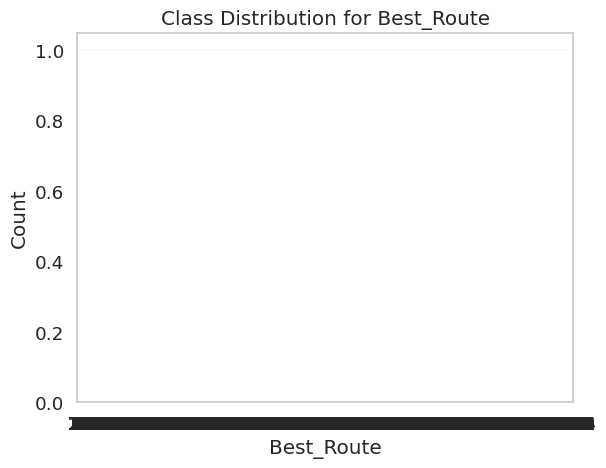

In [47]:
# Check class distribution in the entire dataset
print("\nClass Distribution in Entire Dataset:")
print(y.value_counts())

# Plot class distribution
sns.countplot(y)
plt.title('Class Distribution for Best_Route')
plt.xlabel('Best_Route')
plt.ylabel('Count')
plt.show()


In [45]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Verify the new class distribution
print("\nClass Distribution After SMOTE:")
print(pd.Series(y_train_res).value_counts())

# Plot the new class distribution
sns.countplot(y_train_res)
plt.title('Class Distribution After SMOTE')
plt.xlabel('Best_Route')
plt.ylabel('Count')
plt.show()


ValueError: The target 'y' needs to have more than 1 class. Got 1 class instead

In [ ]:
# Define LightGBM parameters
params = {
    'objective': 'binary',
    'metric': ['binary_logloss', 'auc'],
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# Create LightGBM datasets
train_data = lgb.Dataset(X_train_res, label=y_train_res)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Train the model with early stopping
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[valid_data],
    early_stopping_rounds=50,
    verbose_eval=100
)


In [ ]:
# Predict probabilities on the test set
y_pred_prob = gbm.predict(X_test, num_iteration=gbm.best_iteration)

# Convert probabilities to binary predictions using a threshold of 0.5
y_pred = [1 if prob >= 0.5 else 0 for prob in y_pred_prob]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)


In [ ]:
# Feature importance based on split
lgb.plot_importance(gbm, max_num_features=15, importance_type='split', figsize=(10,6))
plt.title('Feature Importance (Split)')
plt.show()

# Feature importance based on gain
lgb.plot_importance(gbm, max_num_features=15, importance_type='gain', figsize=(10,6))
plt.title('Feature Importance (Gain)')
plt.show()


In [ ]:
import shap

# Initialize SHAP explainer
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(X_test)

# SHAP Summary Plot (Bar)
shap.summary_plot(shap_values, X_test, plot_type="bar")

# SHAP Summary Plot (Dot)
shap.summary_plot(shap_values, X_test)


In [ ]:
# Save the model to a file
gbm.save_model('lightgbm_best_bus_route_model.txt')


In [ ]:
# Load the model from the file
gbm_loaded = lgb.Booster(model_file='lightgbm_best_bus_route_model.txt')

# Verify by making a prediction
sample = X_test.iloc[:5]
sample_pred_prob = gbm_loaded.predict(sample, num_iteration=gbm_loaded.best_iteration)
print(sample_pred_prob)
